In [120]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [121]:
import pandas as pd
dataset=pd.read_csv("noshowappointments/KaggleV2-May-2016.csv")

In [122]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [123]:
dataset['ScheduledDay'] = pd.to_datetime(dataset['ScheduledDay'])
dataset['AppointmentDay'] = pd.to_datetime(dataset['AppointmentDay'])

dataset['ScheduledDay_DayOfWeek'] = dataset['ScheduledDay'].dt.dayofweek
dataset['ScheduledDay_Hour'] = dataset['ScheduledDay'].dt.hour

dataset['AppointmentDay_DayOfWeek'] = dataset['AppointmentDay'].dt.dayofweek
dataset['AppointmentDay_Month'] = dataset['AppointmentDay'].dt.month

dataset['Days_Before_Appointment'] = (dataset['AppointmentDay'] - dataset['ScheduledDay']).dt.days
print(dataset.head())

      PatientId  AppointmentID Gender              ScheduledDay  \
0  2.987250e+13        5642903      F 2016-04-29 18:38:08+00:00   
1  5.589978e+14        5642503      M 2016-04-29 16:08:27+00:00   
2  4.262962e+12        5642549      F 2016-04-29 16:19:04+00:00   
3  8.679512e+11        5642828      F 2016-04-29 17:29:31+00:00   
4  8.841186e+12        5642494      F 2016-04-29 16:07:23+00:00   

             AppointmentDay  Age      Neighbourhood  Scholarship  \
0 2016-04-29 00:00:00+00:00   62    JARDIM DA PENHA            0   
1 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   
2 2016-04-29 00:00:00+00:00   62      MATA DA PRAIA            0   
3 2016-04-29 00:00:00+00:00    8  PONTAL DE CAMBURI            0   
4 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   

   Hipertension  Diabetes  Alcoholism  Handcap  SMS_received No-show  \
0             1         0           0        0             0      No   
1             0         0           0       

In [124]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

columns_to_one_hot = ['Gender']

dataset_encoded = pd.get_dummies(dataset.copy(), columns=columns_to_one_hot,drop_first=True)

for col in dataset_encoded.columns:
    if dataset_encoded[col].dtype == 'bool':
        dataset_encoded[col] = dataset_encoded[col].astype(int)

le = LabelEncoder()
dataset_encoded["No-show"] = le.fit_transform(dataset_encoded["No-show"])
oe=OrdinalEncoder()
dataset_encoded["Neighbourhood"] = le.fit_transform(dataset_encoded["Neighbourhood"])

print("Encoded DataFrame Head:")
print(dataset_encoded.head(3))

Encoded DataFrame Head:
      PatientId  AppointmentID              ScheduledDay  \
0  2.987250e+13        5642903 2016-04-29 18:38:08+00:00   
1  5.589978e+14        5642503 2016-04-29 16:08:27+00:00   
2  4.262962e+12        5642549 2016-04-29 16:19:04+00:00   

             AppointmentDay  Age  Neighbourhood  Scholarship  Hipertension  \
0 2016-04-29 00:00:00+00:00   62             39            0             1   
1 2016-04-29 00:00:00+00:00   56             39            0             0   
2 2016-04-29 00:00:00+00:00   62             45            0             0   

   Diabetes  Alcoholism  Handcap  SMS_received  No-show  \
0         0           0        0             0        0   
1         0           0        0             0        0   
2         0           0        0             0        0   

   ScheduledDay_DayOfWeek  ScheduledDay_Hour  AppointmentDay_DayOfWeek  \
0                       4                 18                         4   
1                       4            

In [125]:
y=np.array(dataset_encoded["No-show"])
X=dataset_encoded.drop(['PatientId', 'AppointmentID','ScheduledDay', 'AppointmentDay','No-show','ScheduledDay_Hour'], axis=1)

print(X.head(3))

   Age  Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
0   62             39            0             1         0           0   
1   56             39            0             0         0           0   
2   62             45            0             0         0           0   

   Handcap  SMS_received  ScheduledDay_DayOfWeek  AppointmentDay_DayOfWeek  \
0        0             0                       4                         4   
1        0             0                       4                         4   
2        0             0                       4                         4   

   AppointmentDay_Month  Days_Before_Appointment  Gender_M  
0                     4                       -1         0  
1                     4                       -1         1  
2                     4                       -1         0  


In [126]:
from sklearn.model_selection import train_test_split
X_train,X_val, y_train, y_val=train_test_split(X,y,test_size=0.33)

In [127]:
scaler = StandardScaler().fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_val_scaled=scaler.transform(X_val)
print(y_train[:10])

[0 1 0 0 1 1 0 0 0 0]


In [128]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)

In [129]:
np.random.seed(2)

class Layer_Dense:
    def __init__(self,n_inputs,n_neurons):
        self.weights=None
        self.biases=np.zeros((1,n_neurons))
        limit = np.sqrt(6 / (n_inputs + n_neurons))
        self.weights = np.random.uniform(-limit, limit, size=(n_inputs, n_neurons))
    def forward(self,inputs):
        self.inputs=inputs
        self.output=np.dot(inputs,self.weights)+self.biases
    def backward(self,dvalues):
        self.dweights=np.dot(self.inputs.T,dvalues)
        self.dbiases=np.sum(dvalues,axis=0,keepdims=True)
        self.dinputs=np.dot(dvalues,self.weights.T)

class Activation_RELU:
    def forward(self,inputs):
        self.inputs=inputs
        self.output=np.maximum(0,inputs)
        
    def backward(self,dvalues):
        self.dinputs=dvalues.copy()
        self.dinputs[self.inputs<=0]=0

class Activation_Softmax:
    def forward(self,inputs):
        self.inputs=inputs
        exp_values=np.exp(inputs-np.max(inputs,axis=1,keepdims=True))
        self.output=exp_values / np.sum(exp_values,axis=1,keepdims=True)

class Loss:
    def calculate(self,output,y):
        sample_losses=self.forward(output,y)
        data_loss=np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):
    def __init__(self, class_weights=None):
        self.class_weights = class_weights 
        
    def forward(self,y_pred,y_true):
        y_pred_clipped=np.clip(y_pred,1e-7,1-1e-7)
        samples=len(y_pred)
        
        if len(y_true.shape)==1:
            correct_confidences=y_pred_clipped[range(samples),y_true]
            y_true_one_hot_temp = np.zeros((samples, y_pred.shape[1]))
            y_true_one_hot_temp[range(samples), y_true] = 1
            
        elif len(y_true.shape)==2:
            correct_confidences=np.sum(y_pred_clipped*y_true,axis=1)
            y_true_one_hot_temp = y_true
        
        log_likelihoods=-np.log(correct_confidences)
        weighted_log_likelihoods = log_likelihoods * np.sum(self.class_weights * y_true_one_hot_temp, axis=1)
        return weighted_log_likelihoods
        
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        if len(y_true.shape)==1:
            y_true_one_hot=np.zeros((samples,len(dvalues[0])))
            y_true_one_hot[range(samples),y_true] = 1
        elif len(y_true.shape)==2:
            y_true_one_hot=y_true
        
        self.dinputs=(dvalues-y_true_one_hot)/samples


In [130]:
class NeuralNetwork:
    def __init__(self,layers,activation_functions,
                 loss_class=Loss_CategoricalCrossentropy,learningrate=0.0001,class_weights=None):
        self.layers=layers
        self.activation_functions=activation_functions
        self.loss_function=loss_class(class_weights=class_weights)
        self.learning_rate=learningrate
        self.current_batch=None
    
    def forward_propagation(self,X):
        current = X
        self.layer_outputs = []
        self.activation_outputs = []


        for k in range(len(self.layers)):
            self.layers[k].forward(current)
            self.layer_outputs.append(self.layers[k].output)

            self.activation_functions[k].forward(self.layers[k].output)
            self.activation_outputs.append(self.activation_functions[k].output)

            current = self.activation_functions[k].output

        return current

    def backward_propagation(self,output,y_true):
        self.loss_function.backward(output,y_true)
        gradients=self.loss_function.dinputs
        for i in reversed(range(len(self.layers))):
            if not isinstance(self.activation_functions[i], Activation_Softmax):
                self.activation_functions[i].inputs = self.layer_outputs[i]
                self.activation_functions[i].backward(gradients)
                gradients=self.activation_functions[i].dinputs
            self.layers[i].inputs = self.activation_outputs[i-1] if i > 0 else self.current_batch
            self.layers[i].backward(gradients)
            gradients=self.layers[i].dinputs
            
    def train(self,X,y,epochs=2500,batch_size=64):
        self.epoch_losses=[]
        for epoch in range(epochs):
            permutation = np.random.permutation(len(X))
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]
            epoch_loss=0
            num_batches=0
            for i in range(0,len(X),batch_size):
                X_batch = X_shuffled[i : i + batch_size]
                y_batch = y_shuffled[i : i + batch_size]

                self.current_batch = X_batch
                output=self.forward_propagation(X_batch)
                batch_loss = self.loss_function.calculate(output, y_batch)
                epoch_loss += batch_loss
                num_batches += 1
                self.backward_propagation(output,y_batch)
                
                for layer in self.layers:
                    layer.weights-=self.learning_rate*layer.dweights
                    layer.biases-=self.learning_rate*layer.dbiases
                    
            avg_epoch_loss = epoch_loss / num_batches
            self.epoch_losses.append(avg_epoch_loss)
            
            if (epoch + 1) % 100 == 0:
                print(f'Epoch: {epoch + 1}, Average Epoch Loss: {avg_epoch_loss:.6f}')
    

In [131]:
neurons=[len(X_train_scaled[0]),32,16,8,2]
layers=[]
activation_functions=[]
for i in range(len(neurons)-1):
    layer_temp=Layer_Dense(neurons[i],neurons[i+1])
    layers.append(layer_temp)
    if i<len(neurons)-2:
        activation_temp=Activation_RELU()
        activation_functions.append(activation_temp)
    else:
        activation_temp=Activation_Softmax()
        activation_functions.append(activation_temp)

In [132]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, auc, precision_recall_curve

In [118]:
model=NeuralNetwork(layers,activation_functions,class_weights=class_weights)
model.train(X_train_scaled,y_train)

print("Training Data")
start_numpy=time.time()
predictions_train=np.argmax(model.forward_propagation(X_train_scaled),axis=1)
numpy_time=time.time()-start_numpy
print("True values: ", y_train[0:10])
print("Predicted values: ", predictions_train[0:10])

threshold=0.25
print("Validation Data")
probabilities_val=model.forward_propagation(X_val_scaled)
predictions_val = (probabilities_val[:, 1] >= threshold).astype(int)

print("True values: ", y_val[0:10])
print("Predicted values: ", predictions_val[0:10])

accuracy_val = np.mean(predictions_val == y_val)
print(f"Validation Accuracy: {accuracy_val:.4f}")

f1_scratch = f1_score(y_val, predictions_val, pos_label=1)
print(f"\nF1-Score: {f1_scratch:.4f}")

precision=precision_score(y_val, predictions_val, pos_label=1)
recall=recall_score(y_val, predictions_val, pos_label=1)
print(f"\nPrecision: {precision:.4f}")
print(f"\nRecall: {recall:.4f}")

precision, recall, _ = precision_recall_curve(y_val, probabilities_val[:, 1])
pr_auc_scratch = auc(recall, precision)
print(f"\nPR_AUC: {pr_auc_scratch:.4f}")

cm_scratch = confusion_matrix(y_val, predictions_val)
print("\nConfusion Matrix:\n", cm_scratch)
print("\nTime Taken by Numpy Implementation", cm_scratch)

Epoch: 100, Average Epoch Loss: 0.863494
Epoch: 200, Average Epoch Loss: 0.844933
Epoch: 300, Average Epoch Loss: 0.835209
Epoch: 400, Average Epoch Loss: 0.824292
Epoch: 500, Average Epoch Loss: 0.818511
Epoch: 600, Average Epoch Loss: 0.813138
Epoch: 700, Average Epoch Loss: 0.807173
Epoch: 800, Average Epoch Loss: 0.803946
Epoch: 900, Average Epoch Loss: 0.802343
Epoch: 1000, Average Epoch Loss: 0.798969
Epoch: 1100, Average Epoch Loss: 0.796927
Epoch: 1200, Average Epoch Loss: 0.794368
Epoch: 1300, Average Epoch Loss: 0.793142
Epoch: 1400, Average Epoch Loss: 0.791826
Epoch: 1500, Average Epoch Loss: 0.790521
Epoch: 1600, Average Epoch Loss: 0.790657
Epoch: 1700, Average Epoch Loss: 0.789702
Epoch: 1800, Average Epoch Loss: 0.789294
Epoch: 1900, Average Epoch Loss: 0.787539
Epoch: 2000, Average Epoch Loss: 0.787950
Epoch: 2100, Average Epoch Loss: 0.789252
Epoch: 2200, Average Epoch Loss: 0.786478
Epoch: 2300, Average Epoch Loss: 0.786104
Epoch: 2400, Average Epoch Loss: 0.786181
E

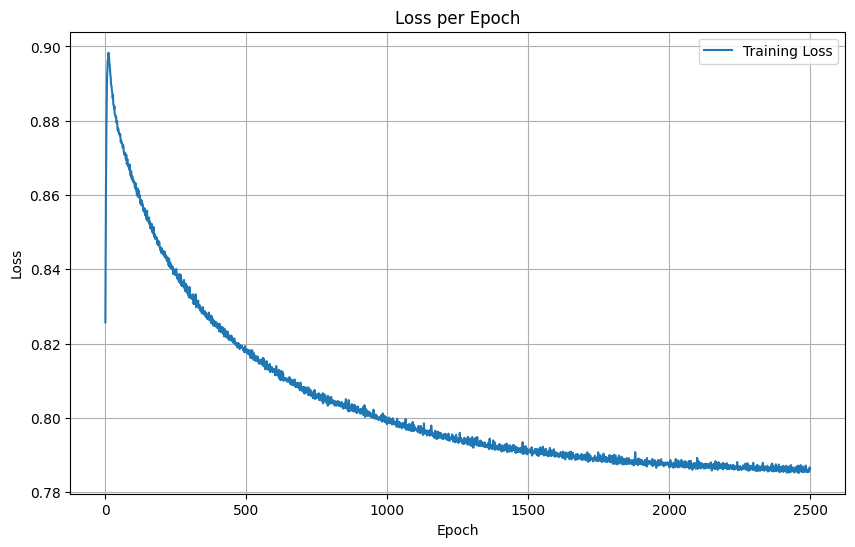

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(model.epoch_losses[0:], label='Training Loss')

plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [137]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_val_tensor = torch.from_numpy(X_val_scaled).float()
y_val_tensor = torch.from_numpy(y_val).long()
print(X_train_tensor)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size_pytorch = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size_pytorch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_pytorch, shuffle=False)
output_classes=2


tensor([[-1.3426, -1.3723, -0.3310,  ..., -0.4414, -0.1417,  1.3620],
        [-0.5640, -1.6406, -0.3310,  ..., -0.4414,  0.4506, -0.7342],
        [ 0.6905, -0.0753,  3.0207,  ..., -0.4414, -0.0759, -0.7342],
        ...,
        [ 0.9068, -0.1647, -0.3310,  ...,  1.6706, -0.0759, -0.7342],
        [ 0.6905,  0.6403, -0.3310,  ..., -0.4414, -0.6025, -0.7342],
        [-0.2179, -1.4617, -0.3310,  ...,  1.6706, -0.6683,  1.3620]])


In [134]:
class PytorchNeuralNetwork(nn.Module):
    def __init__(self,input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(PytorchNeuralNetwork,self).__init__()
        self.l1=nn.Linear(input_size, hidden_size1)
        self.relu1=nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.l2=nn.Linear(hidden_size1, hidden_size2)
        self.relu2=nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.l3=nn.Linear(hidden_size2, hidden_size3)
        self.relu3=nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.l4=nn.Linear(hidden_size3, output_size)
        
    def forward(self,X):
        out=self.l1(X)
        out=self.relu1(out)
        out=self.dropout1(out)
        out=self.l2(out)
        out=self.relu2(out)
        out=self.dropout2(out)
        out=self.l3(out)
        out=self.relu3(out)
        out=self.dropout3(out)
        out=self.l4(out)
        return out
        

In [140]:
Pytorch_model=PytorchNeuralNetwork(X_train_scaled.shape[1],32,16,8,output_classes)
Pytorch_model = Pytorch_model.to(device)
class_weights_tensor = torch.from_numpy(class_weights).float().to(device)
loss_function=nn.CrossEntropyLoss(weight=class_weights_tensor)
learning_rate=0.0001
optimizer=torch.optim.Adam(Pytorch_model.parameters(),lr=learning_rate,weight_decay=1e-5)

start_pytorch=time.time()
epochs=1500
pytorch_losses=[]
for epoch in range(epochs):
    total_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs=Pytorch_model(inputs)
        loss=loss_function(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()


    avg_loss=total_loss/len(train_loader)
    pytorch_losses.append(avg_loss)
    if (epoch+1)%100 == 0:
        print(f'Epoch: {epoch+1}/{epochs}, Avg Batch Loss: {avg_loss:.6f}')
pytorch_time=time.time()-start_pytorch

threshold=0.22
with torch.no_grad():
    total_val_loss=0
    num_correct=0
    num_samples=0

    all_labels = []
    all_predictions_class = [] 
    all_probabilities = []
    
    for inputs,labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs=Pytorch_model(inputs)
        loss = loss_function(outputs, labels)
        total_val_loss += loss.item()

        probabilities = torch.softmax(outputs, dim=1)
#positive_class_probabilities = probabilities[:, 1]
        predictions = torch.argmax(probabilities,dim=1)
#(positive_class_probabilities >= threshold).int()
        
        num_samples+=labels.shape[0]
        num_correct+=(predictions==labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy()) 
        all_predictions_class.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)

    all_probabilities_val = np.array(all_probabilities)
    all_labels_val = np.array(all_labels)
    all_predictions_val = np.array(all_predictions_class)

    f1_pytorch = f1_score(all_labels_val, all_predictions_val, pos_label=1)
    precision, recall, _ = precision_recall_curve(all_labels_val, all_probabilities_val[:, 1])
    pr_auc_pytorch = auc(recall, precision)
    cm_pytorch = confusion_matrix(all_labels_val, all_predictions_val)
    acc_pytorch=100*(num_correct/num_samples)
    

print("True values: ", all_labels_val[0:10])
print("Predicted values: ", all_predictions_val[0:10])
print(f"Validation Accuracy: {acc_pytorch:.2f}%")
print(f"F1 score: {f1_pytorch:.4f}")
print(f"PR AUC: {pr_auc_pytorch:.4f}")
print("Confusion Matrix:\n", cm_pytorch)
print(f"Time: {pytorch_time}")

Epoch: 100/1500, Avg Batch Loss: 0.603585
Epoch: 200/1500, Avg Batch Loss: 0.602062
Epoch: 300/1500, Avg Batch Loss: 0.600022
Epoch: 400/1500, Avg Batch Loss: 0.599504
Epoch: 500/1500, Avg Batch Loss: 0.599732
Epoch: 600/1500, Avg Batch Loss: 0.596730
Epoch: 700/1500, Avg Batch Loss: 0.598006
Epoch: 800/1500, Avg Batch Loss: 0.597798
Epoch: 900/1500, Avg Batch Loss: 0.596979
Epoch: 1000/1500, Avg Batch Loss: 0.595498
Epoch: 1100/1500, Avg Batch Loss: 0.596569
Epoch: 1200/1500, Avg Batch Loss: 0.597021
Epoch: 1300/1500, Avg Batch Loss: 0.594889
Epoch: 1400/1500, Avg Batch Loss: 0.595550
Epoch: 1500/1500, Avg Batch Loss: 0.595652
True values:  [1 0 0 0 0 0 0 1 0 0]
Predicted values:  [1 0 0 0 0 1 0 0 0 0]
Validation Accuracy: 59.57%
F1 score: 0.4419
PR AUC: 0.3383
Confusion Matrix:
 [[15892 13229]
 [ 1516  5837]]
Time: 3448.2119550704956


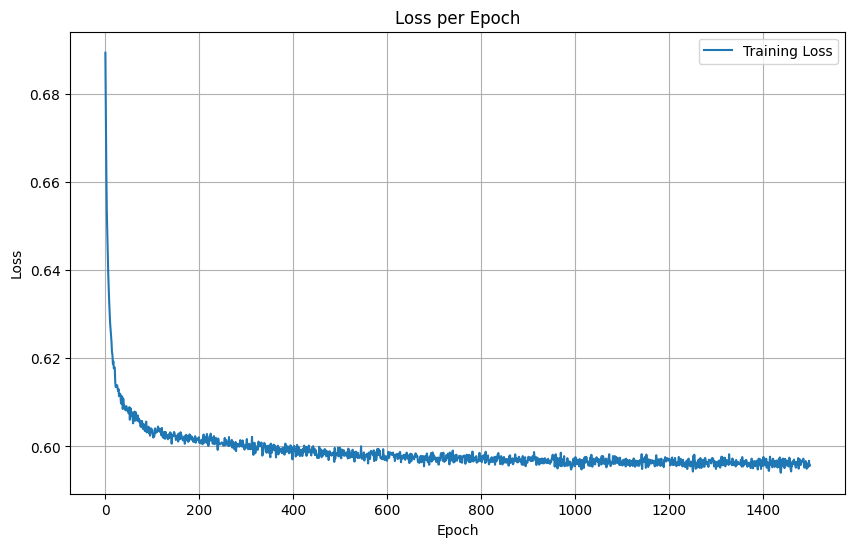

In [141]:
plt.figure(figsize=(10, 6))
plt.plot(pytorch_losses, label='Training Loss')

plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()